# Tutorial for Task 1: Segmentation using a Python function
This notebook illustrates how to:
- define a Python fonction which produces solutions for task 1;
- run this function;
- evaluate its performance.

## Dataset loading
First, let us load the dataset. In this tutorial we use a smaller version of the dataset to accelerate the computations, but the actual code would be exactly the same (just remove the `data_home` parameter).

In [1]:
from smartdoc15_ch1 import Dataset, evaluate_segmentation

In [2]:
d = Dataset(data_home="/data/competitions/2015-ICDAR-smartdoc/challenge1/99-computable-version-2017-test",
           download_if_missing=False)

## Task definition
Task 1 is a segmentation task. Given a frame image, you should return the coordinates of the 4 corners of the document object contained in the image, as illustrated in the following figure.

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
d0 = d[0]
d0_img_c = d0.read_image(color=True)
d0_seg_x = [d0[k] for k in ["tl_x", "bl_x", "br_x", "tr_x", "tl_x"]]
d0_seg_y = [d0[k] for k in ["tl_y", "bl_y", "br_y", "tr_y", "tl_y"]]

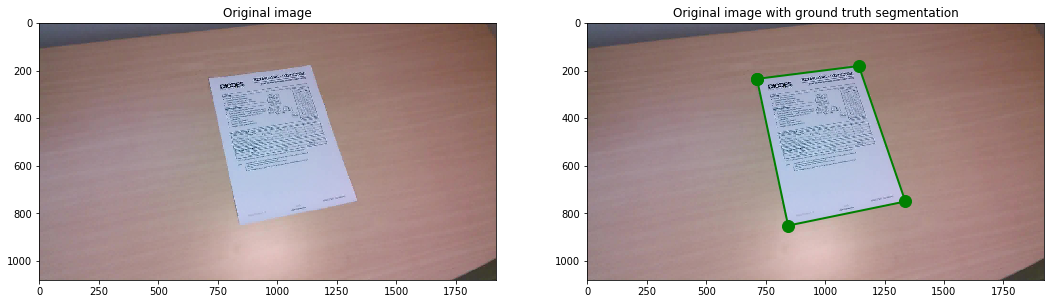

In [5]:
plt.figure(figsize=(18,10))
plt.subplot(1,2,1)
plt.imshow(d0_img_c)
plt.title("Original image")
plt.subplot(1,2,2)
plt.imshow(d0_img_c)
plt.plot(d0_seg_x, d0_seg_y, 'go-', linewidth=2, markersize=12)
plt.title("Original image with ground truth segmentation")
plt.show()

The evaluation function `evaluate_segmentation` requires that you create an array with the following format:
- each row corresponds to the segmentation of the image with the same index in the dataset
- each columns corresponds to a corner coordinate, in the following order: top left x ("tl_x"), top left y ("tl_y"), bottom left x ("bl_x"), bottom left y ("bl_y"), bottom right x ("br_x"), bottom right y ("br_y"), top right x ("tr_x") and top right y ("tr_y").

The signature of the function we have to code is therefore:

       np.array ---> list or array of floats
    input image |--> tl_x, tl_y, bl_x, bl_y, br_x, br_y, tr_x, tr_y

## A simple document object detector
We now define a simple function which makes use of OpenCV primitives to quickly extract a candidate for the outline of the document object.

You may need to install (locally) the Python wrapper for OpenCV by entering the following command in your shell:

    pip install opencv-python

In [6]:
import numpy as np
import cv2

In [7]:
def detect_object(frame_image, num_pyrdown=2):
    # Reduce the image
    img = frame_image
    for _ in range(num_pyrdown):
        img = cv2.pyrDown(img)
    
    # Convert to grayscale if we have a color image
    if len(img.shape) == 3:
        # we keep only the luminance
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[..., 1]
        
    height, width = img.shape
    cx = width // 2
    cy = height // 2

    # Default value for results: return fhe whole frame if we cannot find any object
    tl_x, tl_y, bl_x, bl_y, br_x, br_y, tr_x, tr_y = (
        0., 0., 
        0., height-1, 
        width-1, height-1, 
        width-1, 0.)

    # Remove small components
    closed = cv2.morphologyEx(img, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8), iterations=5)
    blurred = cv2.blur(closed, (3,3))

    # Binarize
    binary = cv2.Canny(blurred.astype(np.uint8), 0, 95, 3)

    # Contour extraction
    # Since opencv 3.2 source image is not modified by this function (and the API changed...)
    _image, contours, _hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Select the best contour
    if len(contours) > 0:
        good_contours = []  # list of contours
        distances = None  # list of floats

        # First check for contours around the center point
        for cnt in contours:
            hull = cv2.convexHull(cnt)
            dist = cv2.pointPolygonTest(hull,(cx,cy), False)  # fast inclusion test
            if dist > 0:  # The center point is included in the convex hull of the contour
                good_contours.append(hull)

        # If no match, pick the contours with the greatest curve length
        if len(good_contours) == 0:
            dists1 = [cv2.arcLength(cnt, False) for cnt in contours]
            idx1 = np.argsort(dists1)[::-1]  # reverse order
            # Keep at most 3 contours
            good_contours = [contours[ii] for ii in idx1[:3]]
            
        # if we finally have good contours
        if len(good_contours) >= 0:
            # Compute exact distances to center
            distances =  [cv2.pointPolygonTest(cnt, (cx,cy), True) for cnt in good_contours]
            idx = np.argsort(distances)  # get the indices to sort the contours by distance
            # keep the best contour
            best_contour = good_contours[idx[0]]
            # Polygonal approximation
            approx = cv2.approxPolyDP(best_contour,0.1*cv2.arcLength(best_contour,True),True)

            # check we have quadrilateral and assign corners
            if len(approx) == 4:              
                xs = [approx[0][0][0],approx[1][0][0],approx[2][0][0],approx[3][0][0]]
                ys = [approx[0][0][1],approx[1][0][1],approx[2][0][1],approx[3][0][1]]
                idx = np.argsort(ys)
                top = [[xs[idx[0]],ys[idx[0]]],[xs[idx[1]],ys[idx[1]]]]
                bottom = [[xs[idx[2]],ys[idx[2]]],[xs[idx[3]],ys[idx[3]]]]
                if top[0][0] > top[1][0]:
                    tl_x, tl_y = top[1]
                    tr_x, tr_y = top[0]
                else:
                    tl_x, tl_y = top[0]
                    tr_x, tr_y = top[1]
                if bottom[0][0] > bottom[1][0]:
                    bl_x, bl_y = bottom[1]
                    br_x, br_y = bottom[0]
                else:
                    bl_x, bl_y = bottom[0]
                    br_x, br_y = bottom[1]

    # Do not forget to scale the coordinates
    if num_pyrdown > 0:
        tl_x, tl_y, bl_x, bl_y, br_x, br_y, tr_x, tr_y = (
            np.array([tl_x, tl_y, bl_x, bl_y, br_x, br_y, tr_x, tr_y])
            * 2**num_pyrdown)

    return tl_x, tl_y, bl_x, bl_y, br_x, br_y, tr_x, tr_y

### Process the previous image

In [8]:
predicted_seg = detect_object(d0_img_c)
predicted_seg

(716, 236, 848, 844, 1332, 744, 1140, 180)

### Display the segmentation (expected and predicted)

In [9]:
d0_predseg_x = tuple(predicted_seg[0::2]) + (predicted_seg[0],)
d0_predseg_y = tuple(predicted_seg[1::2]) + (predicted_seg[1],)
d0_predseg_x, d0_predseg_y

((716, 848, 1332, 1140, 716), (236, 844, 744, 180, 236))

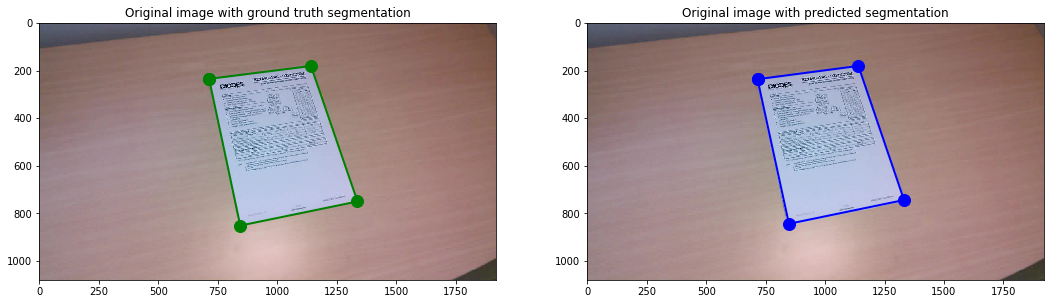

In [10]:
plt.figure(figsize=(18,10))
plt.subplot(1,2,1)
plt.imshow(d0_img_c)
plt.plot(d0_seg_x, d0_seg_y, 'go-', linewidth=2, markersize=12)
plt.title("Original image with ground truth segmentation")
plt.subplot(1,2,2)
plt.imshow(d0_img_c)
plt.plot(d0_predseg_x, d0_predseg_y, 'bo-', linewidth=2, markersize=12)
plt.title("Original image with predicted segmentation")
plt.show()

## Evaluating the performance on Task 1
Our document object detector seems to work (at least on this image). Let us now test it on the complete dataset.

We will process all images and store the segmentation results, then we will call the evaluation function.

On the real dataset, you may want to parallelize such process, using the Joblib library for instance.

**The code in the two cells below is the only code you need (beside your function definition) to evaluate a given document object detection function.**

If you want to evaluate the performance of an external (non Python) program for this task, you will need to:
1. process the images in the canonical order of the dataset (see the "frames/metadata.csv.gz" file) and store results with this same order;
2. load your results in Python and parse your result file(s) to produce a single list or array of `n` row and 8 columns, `n` being the number of frames;
3. call the `evaluate_segmentation` function with the appropriate values.

In [11]:
predicted_segmentations = []
for ii, frame in enumerate(d):
    print("Processing image %2d/%d: %s" % (ii+1, len(d), frame["image_path"]))
    predicted_segmentations.append(detect_object(frame.read_image(color=True)))

Processing image  1/50: background01/datasheet004/frame_0181.jpeg
Processing image  2/50: background02/tax003/frame_0128.jpeg
Processing image  3/50: background03/patent002/frame_0163.jpeg
Processing image  4/50: background04/letter001/frame_0116.jpeg
Processing image  5/50: background02/magazine001/frame_0045.jpeg
Processing image  6/50: background05/patent001/frame_0062.jpeg
Processing image  7/50: background04/patent005/frame_0048.jpeg
Processing image  8/50: background02/patent002/frame_0106.jpeg
Processing image  9/50: background03/tax002/frame_0158.jpeg
Processing image 10/50: background02/datasheet003/frame_0129.jpeg
Processing image 11/50: background04/letter001/frame_0094.jpeg
Processing image 12/50: background01/datasheet004/frame_0130.jpeg
Processing image 13/50: background04/paper002/frame_0071.jpeg
Processing image 14/50: background02/paper001/frame_0209.jpeg
Processing image 15/50: background02/paper003/frame_0029.jpeg
Processing image 16/50: background01/paper004/frame_0

In [12]:
metrics = evaluate_segmentation(predicted_segmentations, d.segmentation_targets, 
                                d.model_shapes, print_summary=True)

----------------------------------------------
   evaluate_segmentation: Evaluation report
----------------------------------------------
metric: IoU (aka Jaccard index)
----------------------------------------------
observations:    50
mean:             0.70 (CI@95%: 0.583, 0.808)
min-max:          0.000 - 0.988
variance:         0.165 (std: 0.406)
----------------------------------------------


In [13]:
# Alternate version using the compact `iter_frame_images` function
# predicted_segmentations = []
# for ii, frame_image in enumerate(d.iter_frame_images(color=True)):
#     print("Processing image %2d/%d" % (ii+1, len(d)))
#     predicted_segmentations.append(detect_object(frame_image))

In [14]:
# or ever shorter
# predicted_segmentations = [detect_object(img) for img in d.iter_frame_images(color=True)]

## Check the results
We can now study which kind of input cause our function to perform well or not.

Let us simply plot the results for the best and the worst scoring images.

In [15]:
bfid = np.argmax(metrics)
best_frame = d[bfid]
wfid = np.argmin(metrics)
worst_frame = d[wfid]

In [16]:
def seg2xylists(seg):
    seg_x = tuple(seg[0::2]) + (seg[0],)
    seg_y = tuple(seg[1::2]) + (seg[1],)
    return seg_x, seg_y

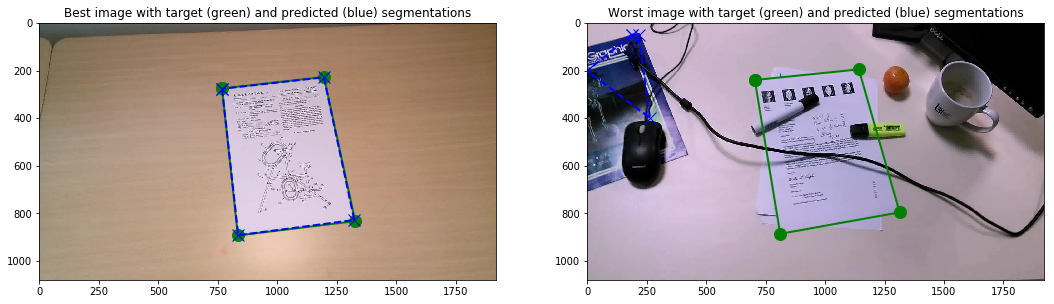

In [17]:
plt.figure(figsize=(18,10))
plt.subplot(1,2,1)
plt.imshow(best_frame.read_image(color=True))
seg_x, seg_y = seg2xylists(d.segmentation_targets[bfid])
plt.plot(seg_x, seg_y, 'go-', linewidth=2, markersize=12)
seg_x, seg_y = seg2xylists(predicted_segmentations[bfid])
plt.plot(seg_x, seg_y, 'bx--', linewidth=2, markersize=12)
plt.title("Best image with target (green) and predicted (blue) segmentations")
plt.subplot(1,2,2)
plt.imshow(worst_frame.read_image(color=True))
seg_x, seg_y = seg2xylists(d.segmentation_targets[wfid])
plt.plot(seg_x, seg_y, 'go-', linewidth=2, markersize=12)
seg_x, seg_y = seg2xylists(predicted_segmentations[wfid])
plt.plot(seg_x, seg_y, 'bx--', linewidth=2, markersize=12)
plt.title("Worst image with target (green) and predicted (blue) segmentations")
plt.show()